In [1]:
# %pip install pycaret[full]
# %pip install scikit-plot

## Preparando o dataset e treinando o modelo

In [2]:
import pandas as pd
from pycaret.regression import *
from pycaret import show_versions

show_versions()


System:
    python: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
executable: /home/marcelo/anaconda3/envs/conda_env3.10/bin/python
   machine: Linux-6.3.8-200.fc38.x86_64-x86_64-with-glibc2.37

PyCaret required dependencies:
                 pip: 23.1.2
          setuptools: 67.8.0
             pycaret: 3.0.4
             IPython: 7.34.0
          ipywidgets: 7.7.5
                tqdm: 4.65.0
               numpy: 1.23.0
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.10.1
              joblib: 1.3.1
             sklearn: 1.2.2
                pyod: 1.1.0
            imblearn: 0.10.1
   category_encoders: 2.6.1
            lightgbm: 3.3.5
               numba: 0.57.1
            requests: 2.31.0
          matplotlib: 3.7.1
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.15.0
    plotly-resampler: Not installed
             kaleido: 0.2.1
           schemdraw: 0.15
         statsmodels: 0.14.0
              sktime: 0.

In [3]:
df = pd.read_csv('./data/ibov.csv', sep=';')
df.drop(['date', 'open', 'high', 'low', 'close', 'date_import', 'ema_200p_diff', 'volume'], axis=1, inplace=True)
df['date_time'] = pd.to_datetime(df['date_time'])
df.dropna(how='any', axis=0, inplace=True)
df = df.sort_values(['date_time', 'symbol'],
              ascending = [True, True])
df.reset_index(inplace = True)
df.drop(['index'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183456 entries, 0 to 183455
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   adj_close  183456 non-null  float64       
 1   symbol     183456 non-null  object        
 2   date_time  183456 non-null  datetime64[ns]
 3   ema_200p   183456 non-null  float64       
 4   rsi        183456 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 7.0+ MB


In [4]:
symbols = set(list(df['symbol']))
symbols

{'ABEV3.SA',
 'ALPA4.SA',
 'AMER3.SA',
 'ARZZ3.SA',
 'ASAI3.SA',
 'AZUL4.SA',
 'B3SA3.SA',
 'BBAS3.SA',
 'BBDC3.SA',
 'BBDC4.SA',
 'BBSE3.SA',
 'BEEF3.SA',
 'BPAC11.SA',
 'BPAN4.SA',
 'BRAP4.SA',
 'BRFS3.SA',
 'BRKM5.SA',
 'CASH3.SA',
 'CCRO3.SA',
 'CIEL3.SA',
 'CMIG4.SA',
 'CMIN3.SA',
 'COGN3.SA',
 'CPFE3.SA',
 'CPLE6.SA',
 'CRFB3.SA',
 'CSAN3.SA',
 'CSNA3.SA',
 'CVCB3.SA',
 'CYRE3.SA',
 'DXCO3.SA',
 'ECOR3.SA',
 'EGIE3.SA',
 'ELET3.SA',
 'ELET6.SA',
 'EMBR3.SA',
 'ENBR3.SA',
 'ENEV3.SA',
 'ENGI11.SA',
 'EQTL3.SA',
 'EZTC3.SA',
 'FLRY3.SA',
 'GGBR4.SA',
 'GOAU4.SA',
 'GOLL4.SA',
 'HAPV3.SA',
 'HYPE3.SA',
 'IGTI11.SA',
 'ITSA4.SA',
 'ITUB4.SA',
 'JBSS3.SA',
 'KLBN11.SA',
 'LREN3.SA',
 'LWSA3.SA',
 'MGLU3.SA',
 'MRFG3.SA',
 'MRVE3.SA',
 'MULT3.SA',
 'NTCO3.SA',
 'PCAR3.SA',
 'PETR3.SA',
 'PETR4.SA',
 'PETZ3.SA',
 'PRIO3.SA',
 'QUAL3.SA',
 'RADL3.SA',
 'RAIL3.SA',
 'RAIZ4.SA',
 'RDOR3.SA',
 'RENT3.SA',
 'RRRP3.SA',
 'SANB11.SA',
 'SBSP3.SA',
 'SLCE3.SA',
 'SMTO3.SA',
 'SOMA3.SA',
 'SUZB3

In [5]:
dataset = pd.DataFrame()
for s in symbols:
  aux = df[df['symbol'] == s]
  aux['adj_close_1'] = aux['adj_close'].shift() # Valor de 1 dia
  aux['adj_close_2'] = aux['adj_close'].shift(2) # Valor de 2 dias

  aux['rsi_1'] = aux['rsi'].shift()
  aux['rsi_2'] = aux['rsi'].shift(2)

  aux['ema_200p_1'] = aux['ema_200p'].shift()
  aux['ema_200p_2'] = aux['ema_200p'].shift(2)

  dataset = pd.concat([dataset, aux])

#dataset.drop(['ema_200p', 'rsi'], axis=1, inplace=True)
dataset.dropna(how='any', axis=0, inplace=True)
dataset

,adj_close,symbol,date_time,ema_200p,rsi,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2
141,15.464302,BBAS3.SA,2013-10-21,13.014263,75.374912,15.601892,15.288196,80.307930,77.140644,12.985830,12.955423
209,15.491820,BBAS3.SA,2013-10-22,13.042643,75.696457,15.464302,15.601892,75.374912,80.307930,13.014263,12.985830
277,15.409271,BBAS3.SA,2013-10-23,13.069711,72.632581,15.491820,15.464302,75.696457,75.374912,13.042643,13.014263
345,15.596379,BBAS3.SA,2013-10-24,13.098566,75.093375,15.409271,15.491820,72.632581,75.696457,13.069711,13.042643
413,15.777991,BBAS3.SA,2013-10-25,13.129122,77.233209,15.596379,15.409271,75.093375,72.632581,13.098566,13.069711
...,...,...,...,...,...,...,...,...,...,...,...
183095,29.370001,TOTS3.SA,2023-06-26,28.590860,50.789104,29.770000,28.969999,54.323825,47.543863,28.583029,28.571100
183183,29.230000,TOTS3.SA,2023-06-27,28.597219,49.573283,29.370001,29.770000,50.789104,54.323825,28.590860,28.583029
183271,28.990000,TOTS3.SA,2023-06-28,28.601127,47.475169,29.230000,29.370001,49.573283,50.789104,28.597219,28.590860
183359,29.570000,TOTS3.SA,2023-06-29,28.610768,52.686712,28.990000,29.230000,47.475169,49.573283,28.601127,28.597219


In [6]:
categorial_features = ['symbol']
numeric_features = ['adj_close_1', 'adj_close_2', 'ema_200p_1', 'ema_200p_1', 'rsi_1', 'rsi_2']
date_features = ['date_time']
ds = dataset.copy()
ds.drop(['rsi', 'ema_200p'], axis=1, inplace=True)
ds

,adj_close,symbol,date_time,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2
141,15.464302,BBAS3.SA,2013-10-21,15.601892,15.288196,80.307930,77.140644,12.985830,12.955423
209,15.491820,BBAS3.SA,2013-10-22,15.464302,15.601892,75.374912,80.307930,13.014263,12.985830
277,15.409271,BBAS3.SA,2013-10-23,15.491820,15.464302,75.696457,75.374912,13.042643,13.014263
345,15.596379,BBAS3.SA,2013-10-24,15.409271,15.491820,72.632581,75.696457,13.069711,13.042643
413,15.777991,BBAS3.SA,2013-10-25,15.596379,15.409271,75.093375,72.632581,13.098566,13.069711
...,...,...,...,...,...,...,...,...,...
183095,29.370001,TOTS3.SA,2023-06-26,29.770000,28.969999,54.323825,47.543863,28.583029,28.571100
183183,29.230000,TOTS3.SA,2023-06-27,29.370001,29.770000,50.789104,54.323825,28.590860,28.583029
183271,28.990000,TOTS3.SA,2023-06-28,29.230000,29.370001,49.573283,50.789104,28.597219,28.590860
183359,29.570000,TOTS3.SA,2023-06-29,28.990000,29.230000,47.475169,49.573283,28.601127,28.597219


In [7]:
exp_name = setup(data = ds,
                 target = 'adj_close',
                 categorical_features=categorial_features,
                 numeric_features=numeric_features,
                 date_features=date_features,
                 fold_strategy = 'timeseries',
                 fold = 3,
                 transform_target = True,
                 session_id = 123,
                 use_gpu = False,
                 )

,Description,Value
0,Session id,123
1,Target,adj_close
2,Target type,Regression
3,Original data shape,"(183280, 9)"
4,Transformed data shape,"(183280, 26)"
5,Transformed train set shape,"(128295, 26)"
6,Transformed test set shape,"(54985, 26)"
7,Numeric features,6
8,Date features,1
9,Categorical features,1


In [8]:
# best = compare_models(sort = 'MAE')
best = create_model('gbr')
#best = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3329,0.3656,0.6046,0.9981,0.0273,0.0213
1,0.3323,0.3510,0.5924,0.9982,0.0269,0.0210
2,0.3350,0.4256,0.6524,0.9978,0.0284,0.0213
Mean,0.3334,0.3807,0.6165,0.9980,0.0275,0.0212
Std,0.0011,0.0323,0.0259,0.0002,0.0006,0.0001


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

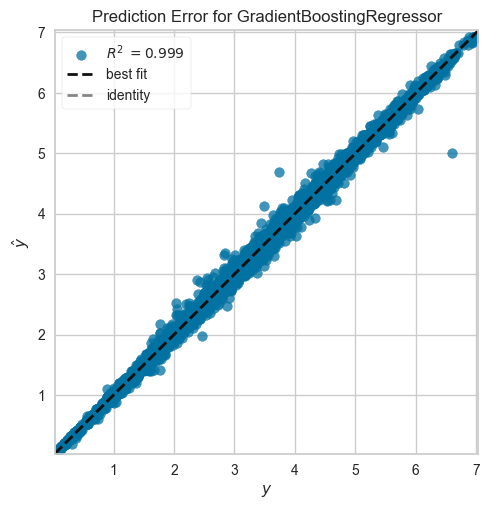

In [9]:
plot_model(best, plot='error')

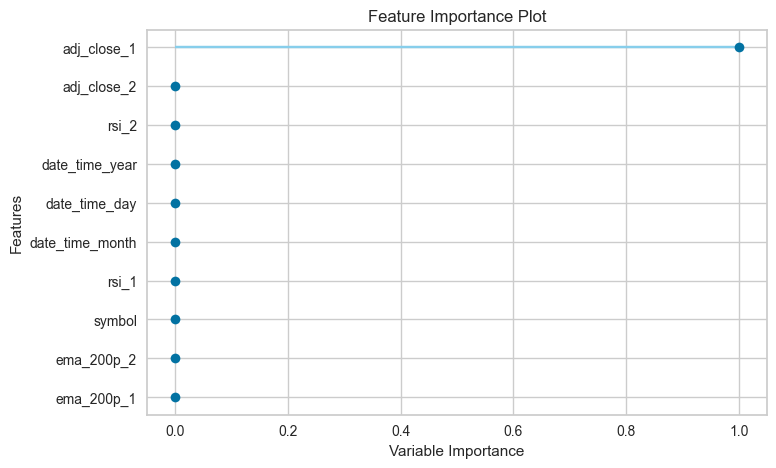

In [10]:
plot_model(best, plot='feature')

In [11]:
prediction_holdout = predict_model(best)
prediction_holdout

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.3328,0.4019,0.6340,0.9980,0.0268,0.0211


,symbol,date_time,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2,adj_close,prediction_label
85220,CPFE3.SA,2018-08-06,14.334258,14.314693,47.640247,46.751259,14.986945,14.993505,3.357543,14.294136
45170,BBSE3.SA,2016-05-31,16.003761,16.120577,43.304134,44.590260,16.151411,16.152897,3.511180,16.053318
154167,VALE3.SA,2022-02-24,77.201553,78.022934,49.699902,52.266499,73.420662,73.382668,6.142593,77.172001
28501,GOLL4.SA,2015-06-17,7.650000,7.730000,45.620953,47.820415,10.267570,10.293939,2.542566,7.577785
41671,GOAU4.SA,2016-03-18,1.294739,1.162623,62.277309,56.934181,2.388427,2.399423,0.934799,1.285900
...,...,...,...,...,...,...,...,...,...,...
91730,B3SA3.SA,2018-12-12,7.725609,7.703210,54.896198,54.270164,6.687788,6.677358,2.577514,7.749068
174041,VBBR3.SA,2023-01-24,14.910000,15.120000,47.143223,50.330456,17.216967,17.240152,3.469230,15.062471
35595,ENGI11.SA,2015-11-10,10.518650,10.635091,44.988884,56.458866,10.288688,10.286374,2.943331,10.537715
129526,AMER3.SA,2020-12-07,76.464149,71.013634,51.261150,40.486782,83.900085,83.974815,6.242004,76.330992


In [12]:
dataset

,adj_close,symbol,date_time,ema_200p,rsi,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2
141,15.464302,BBAS3.SA,2013-10-21,13.014263,75.374912,15.601892,15.288196,80.307930,77.140644,12.985830,12.955423
209,15.491820,BBAS3.SA,2013-10-22,13.042643,75.696457,15.464302,15.601892,75.374912,80.307930,13.014263,12.985830
277,15.409271,BBAS3.SA,2013-10-23,13.069711,72.632581,15.491820,15.464302,75.696457,75.374912,13.042643,13.014263
345,15.596379,BBAS3.SA,2013-10-24,13.098566,75.093375,15.409271,15.491820,72.632581,75.696457,13.069711,13.042643
413,15.777991,BBAS3.SA,2013-10-25,13.129122,77.233209,15.596379,15.409271,75.093375,72.632581,13.098566,13.069711
...,...,...,...,...,...,...,...,...,...,...,...
183095,29.370001,TOTS3.SA,2023-06-26,28.590860,50.789104,29.770000,28.969999,54.323825,47.543863,28.583029,28.571100
183183,29.230000,TOTS3.SA,2023-06-27,28.597219,49.573283,29.370001,29.770000,50.789104,54.323825,28.590860,28.583029
183271,28.990000,TOTS3.SA,2023-06-28,28.601127,47.475169,29.230000,29.370001,49.573283,50.789104,28.597219,28.590860
183359,29.570000,TOTS3.SA,2023-06-29,28.610768,52.686712,28.990000,29.230000,47.475169,49.573283,28.601127,28.597219


In [13]:
ds_pred = pd.DataFrame(dataset[['symbol',	'date_time',	'adj_close_1',	'adj_close_2',	'rsi_1',	'rsi_2',	'ema_200p_1',	'ema_200p_2']])
ds_pred['adj_close_original'] = dataset['adj_close']

In [14]:
ds_pred

,symbol,date_time,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2,adj_close_original
141,BBAS3.SA,2013-10-21,15.601892,15.288196,80.307930,77.140644,12.985830,12.955423,15.464302
209,BBAS3.SA,2013-10-22,15.464302,15.601892,75.374912,80.307930,13.014263,12.985830,15.491820
277,BBAS3.SA,2013-10-23,15.491820,15.464302,75.696457,75.374912,13.042643,13.014263,15.409271
345,BBAS3.SA,2013-10-24,15.409271,15.491820,72.632581,75.696457,13.069711,13.042643,15.596379
413,BBAS3.SA,2013-10-25,15.596379,15.409271,75.093375,72.632581,13.098566,13.069711,15.777991
...,...,...,...,...,...,...,...,...,...
183095,TOTS3.SA,2023-06-26,29.770000,28.969999,54.323825,47.543863,28.583029,28.571100,29.370001
183183,TOTS3.SA,2023-06-27,29.370001,29.770000,50.789104,54.323825,28.590860,28.583029,29.230000
183271,TOTS3.SA,2023-06-28,29.230000,29.370001,49.573283,50.789104,28.597219,28.590860,28.990000
183359,TOTS3.SA,2023-06-29,28.990000,29.230000,47.475169,49.573283,28.601127,28.597219,29.570000


In [15]:
predictions = predict_model(best, data=ds_pred)
predictions

,symbol,date_time,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2,adj_close_original,prediction_label
141,BBAS3.SA,2013-10-21,15.601892,15.288196,80.307930,77.140648,12.985830,12.955422,15.464302,15.778348
209,BBAS3.SA,2013-10-22,15.464302,15.601892,75.374908,80.307930,13.014263,12.985830,15.491820,15.427877
277,BBAS3.SA,2013-10-23,15.491820,15.464302,75.696457,75.374908,13.042643,13.014263,15.409271,15.427877
345,BBAS3.SA,2013-10-24,15.409271,15.491820,72.632584,75.696457,13.069711,13.042643,15.596379,15.427877
413,BBAS3.SA,2013-10-25,15.596379,15.409271,75.093376,72.632584,13.098566,13.069711,15.777991,15.778348
...,...,...,...,...,...,...,...,...,...,...
183095,TOTS3.SA,2023-06-26,29.770000,28.969999,54.323826,47.543861,28.583029,28.571100,29.370001,29.518898
183183,TOTS3.SA,2023-06-27,29.370001,29.770000,50.789104,54.323826,28.590860,28.583029,29.230000,29.157586
183271,TOTS3.SA,2023-06-28,29.230000,29.370001,49.573284,50.789104,28.597219,28.590860,28.990000,29.158783
183359,TOTS3.SA,2023-06-29,28.990000,29.230000,47.475170,49.573284,28.601128,28.597219,29.570000,29.045702


In [16]:
import plotly.express as px
data = predictions[predictions['symbol'] == 'BBAS3.SA']
fig = px.line(data, x="date_time", y=['adj_close_original', 'prediction_label'], template = 'plotly_dark', range_x=['2022-01-01', '2023-05-31'])
fig.show()

## Previsão do valor das ações

In [18]:
max_date = list(dataset['date_time'].tail(2)) # Recupera últimos dois dias de cotação
ds_filter_date = dataset[dataset['date_time'] >= max_date[0]]
ds_filter_date

,adj_close,symbol,date_time,ema_200p,rsi,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2
183287,50.049999,BBAS3.SA,2023-06-29,39.494259,64.379745,49.590000,50.200001,62.270091,67.168665,39.388171,39.285640
183375,49.400002,BBAS3.SA,2023-06-30,39.592824,59.331392,50.049999,49.590000,64.379745,62.270091,39.494259,39.388171
183301,4.260000,CMIN3.SA,2023-06-29,4.114316,39.624494,4.250000,4.350000,38.931635,43.574925,4.112848,4.111465
183389,4.180000,CMIN3.SA,2023-06-30,4.114971,36.096257,4.260000,4.250000,39.624494,38.931635,4.114316,4.112848
183321,15.890000,FLRY3.SA,2023-06-29,14.997382,56.827724,15.590000,15.600000,52.359676,52.527946,14.988411,14.982365
...,...,...,...,...,...,...,...,...,...,...,...
183451,18.049999,VBBR3.SA,2023-06-30,16.148600,60.434761,18.000000,16.990000,59.962417,48.409644,16.129491,16.110692
183319,31.410000,EQTL3.SA,2023-06-29,27.156530,64.879365,31.240000,31.320000,63.529184,64.614650,27.113782,27.072312
183407,32.150002,EQTL3.SA,2023-06-30,27.206217,70.073065,31.410000,31.240000,64.879365,63.529184,27.156530,27.113782
183359,29.570000,TOTS3.SA,2023-06-29,28.610768,52.686712,28.990000,29.230000,47.475169,49.573283,28.601127,28.597219


In [19]:
import datetime

ds_future = pd.DataFrame()
for s in symbols:
  filter_symbol = ds_filter_date[ds_filter_date['symbol'] == s]
  #print(s, filter_symbol['adj_close'].values)
  aux = pd.DataFrame( data = {'date_time': [max_date[1] + datetime.timedelta(days=1)]})
  aux['symbol'] = s
  aux['adj_close_1'] = filter_symbol['adj_close'].values[1] # Valor de 1 dia atrás
  aux['adj_close_2'] = filter_symbol['adj_close'].values[0] # Valor de 2 dias atrás

  aux['rsi_1'] = filter_symbol['rsi'].values[1]
  aux['rsi_2'] = filter_symbol['rsi'].values[0]

  aux['ema_200p_1'] = filter_symbol['ema_200p'].values[1]
  aux['ema_200p_2'] = filter_symbol['ema_200p'].values[0]

  ds_future = pd.concat([ds_future, aux])

ds_future.reset_index(inplace=True)
ds_future.index = ds_future.index + ds_pred.index.max() + 1
ds_future.drop(columns='index', inplace=True)
ds_future

,date_time,symbol,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2
183456,2023-07-01,BBAS3.SA,49.400002,50.049999,59.331392,64.379745,39.592824,39.494259
183457,2023-07-01,CMIN3.SA,4.180000,4.260000,36.096257,39.624494,4.114971,4.114316
183458,2023-07-01,FLRY3.SA,16.049999,15.890000,59.034419,56.827724,15.007856,14.997382
183459,2023-07-01,KLBN11.SA,21.770000,21.570000,49.793452,46.922495,19.863990,19.844834
183460,2023-07-01,GGBR4.SA,25.070000,25.280001,48.745159,51.489136,24.902621,24.900939
...,...,...,...,...,...,...,...,...
183539,2023-07-01,RAIZ4.SA,4.400000,4.590000,67.905929,81.568823,3.653107,3.645534
183540,2023-07-01,COGN3.SA,3.260000,3.250000,61.502358,61.133192,2.485000,2.477211
183541,2023-07-01,VBBR3.SA,18.049999,18.000000,60.434761,59.962417,16.148600,16.129491
183542,2023-07-01,EQTL3.SA,32.150002,31.410000,70.073065,64.879365,27.206217,27.156530


In [25]:
import numpy as np
pred_future = predict_model(best, data=ds_future)
pred_future['status'] = np.where(pred_future['adj_close_1'] > pred_future['prediction_label'], 'VAI CAIR','VAI SUBIR')
pred_future['percentual'] = ((pred_future['prediction_label'] - pred_future['adj_close_1']) / pred_future['adj_close_1'] * 100)
pred_future

,date_time,symbol,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2,prediction_label,status,percentual
183456,2023-07-01,BBAS3.SA,49.400002,50.049999,59.331390,64.379745,39.592823,39.494259,49.317762,VAI CAIR,-0.166477
183457,2023-07-01,CMIN3.SA,4.180000,4.260000,36.096256,39.624493,4.114971,4.114316,4.211309,VAI SUBIR,0.749034
183458,2023-07-01,FLRY3.SA,16.049999,15.890000,59.034420,56.827724,15.007855,14.997382,16.212853,VAI SUBIR,1.014665
183459,2023-07-01,KLBN11.SA,21.770000,21.570000,49.793453,46.922493,19.863989,19.844833,21.812524,VAI SUBIR,0.195330
183460,2023-07-01,GGBR4.SA,25.070000,25.280001,48.745159,51.489136,24.902620,24.900938,24.960036,VAI CAIR,-0.438627
...,...,...,...,...,...,...,...,...,...,...,...
183539,2023-07-01,RAIZ4.SA,4.400000,4.590000,67.905930,81.568825,3.653107,3.645535,4.447531,VAI SUBIR,1.080245
183540,2023-07-01,COGN3.SA,3.260000,3.250000,61.502357,61.133190,2.485000,2.477211,3.233523,VAI CAIR,-0.812193
183541,2023-07-01,VBBR3.SA,18.049999,18.000000,60.434761,59.962418,16.148600,16.129490,18.205446,VAI SUBIR,0.861200
183542,2023-07-01,EQTL3.SA,32.150002,31.410000,70.073067,64.879364,27.206217,27.156530,31.944530,VAI CAIR,-0.639103


In [24]:
pred_future[pred_future['symbol'] == 'BBAS3.SA']

,date_time,symbol,adj_close_1,adj_close_2,rsi_1,rsi_2,ema_200p_1,ema_200p_2,prediction_label,status,percentual
183456,2023-07-01,BBAS3.SA,49.400002,50.049999,59.33139,64.379745,39.592823,39.494259,49.317762,VAI CAIR,0.166477
